In [30]:
import json
import pandas as pd
import plotly.express as px
import numpy as np
from wordcloud import *
import matplotlib.pyplot as plt

In [31]:
with open('../data/docs.json', encoding = "utf8") as f:
    docs = json.load(f)

# Mots par document (sans ponctuation, sans stop-words)

In [32]:
nbDocs = len(docs)
tailleDocs = [len(doc) for doc in docs]
nbMots = sum(tailleDocs)

print(f"Nombre de documents : {nbDocs} | Nombre de mots : {nbMots}")

Nombre de documents : 9501 | Nombre de mots : 71333


In [33]:
tailleDocs = pd.DataFrame(tailleDocs, columns = ["Lemme"])

fig = px.histogram(tailleDocs, x = "Lemme", title = "Histogramme du nombre de mots par documents")
fig.show()

# Importance des lemmes

## Présence globale (fréquence d'apparition sur le corpus)

In [34]:
freqMots = {}
ensembleMots = set()
for doc in docs:
    for mot in doc:
        if mot not in freqMots:
            ensembleMots.add(mot)
            freqMots[mot] = 1
        else:
            freqMots[mot] += 1

Enregistrement des lemmes (uniques) dans un fichier texte

In [35]:
file = open("../data/liste_lemmes.txt", 'w')
for lemme in freqMots.keys():
    file.writelines(lemme + '\n')
file.close()

Ordonnancement décroissant, transformation en _dataframe_

In [36]:
freqMots = sorted(freqMots.items(), key = lambda m: m[1], reverse = True)
freqMots = pd.DataFrame(freqMots, columns = ['Lemme', 'Fréquence'])
freqMots['Fréquence'] *= 100 / nbMots

### Lemmes les plus utilisés (représentatifs du sujet)

In [37]:
nbLemmesAfficher = 10
fig = px.bar(freqMots.iloc[:nbLemmesAfficher,:], x = 'Lemme', y = 'Fréquence',
title = "Fréquence (%) d'apparition des lemmes dans les propositions")
fig.show()

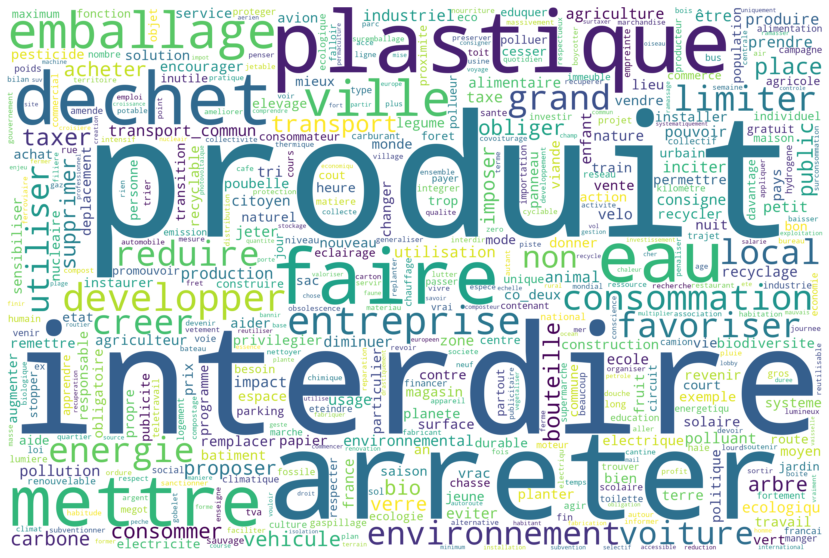

In [47]:
#Word Cloud
dict_wordcloud = freqMots.copy()
dict_wordcloud = dict_wordcloud.set_index("Lemme")
wordcloud = WordCloud(background_color="white", width=3000, height=2000, max_words=500)
wordcloud.generate_from_frequencies(frequencies=dict_wordcloud.to_dict()["Fréquence"])
plt.figure(figsize=[15,10])
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Lemmes les moins utilisés (les plus discriminants)

In [ ]:
freqMin = 100 / nbMots
motsUniques = [freqMots.loc[i,"Lemme"] for i in range(len(freqMots)) if freqMots.loc[i,"Fréquence"] == freqMin]
del freqMin

In [ ]:
print(f"Nombre ; Proportion de mots n'ayant été utilisés qu'une seule fois sur l'ensemble des documents : {len(motsUniques)} ; {100 * len(motsUniques) / len(freqMots)} %.")

Nombre ; Proportion de mots n'ayant été utilisés qu'une seule fois sur l'ensemble des documents : 3266 ; 45.16664361775688 %.


## Termes discriminants (IDF, nombre de documents possédant chaque mot)

In [ ]:
idf = {}
for mot in ensembleMots:
    nbDocsMotPresent = 0
    for doc in docs:
        if mot in doc:
            nbDocsMotPresent += 1
    idf[mot] = np.log(nbDocs / nbDocsMotPresent)

Ordonnancement décroissant, transformation en _dataframe_

In [ ]:
idf = sorted(idf.items(), key = lambda m: m[1], reverse = True)
idf = pd.DataFrame(idf, columns = ['Lemme', 'IDF'])

In [ ]:
#nbLemmesAfficher = 20
fig = px.bar(idf.loc[:,:], x = 'Lemme', y = 'IDF',
title = "IDF des différents lemmes")
fig.show()